In [14]:
# August 25 2017
# This file is for experiments with student2 4 skills and training trajectory length 5
# to check different architectures and whether they can learn good models
# This uses student2a where transitions happen after observations

%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import scipy as sp
import six
import pickle
from matplotlib.pyplot import *

def ixs2ranks(ixs):
    ranks = np.zeros(ixs.shape,dtype=np.int)
    for r,i in enumerate(ixs):
        ranks[i] = r
    return ranks

def extract_ensemble_data(outdata):
    split_num = len(outdata)
    #six.print_(len(outdata[0]))
    #six.print_(len(outdata[0][0]))
    #six.print_(len(outdata[0][0][0]))
    
    sq = np.mean([ [ trial[0][1][1]  for trial in split] for split in outdata ], axis=1)
    sim_sq = np.mean([ [ trial[0][1][3]  for trial in split] for split in outdata ], axis=1)
    
    return sq, sim_sq

def extract_ensemble_last_step_error(outdata):
    split_num = len(outdata)
    #six.print_(len(outdata[0]))
    #six.print_(len(outdata[0][0]))
    #six.print_(len(outdata[0][0][0]))
    
    random_errors = np.mean([ [ trial[0][1][0][-1]  for trial in split] for split in outdata ], axis=1)
    random_errors_std = np.std([ [ trial[0][1][0][-1]  for trial in split] for split in outdata ], axis=1)
    expert_errors = np.mean([ [ trial[0][1][1][-1]  for trial in split] for split in outdata ], axis=1)
    expert_errors_std = np.std([ [ trial[0][1][1][-1]  for trial in split] for split in outdata ], axis=1)
    return random_errors, random_errors_std, expert_errors, expert_errors_std

def extract_last_step_error(multistep):
    random_errors = np.array([model_output[0][0][-1] for model_output in multistep])
    expert_errors = np.array([model_output[0][1][-1] for model_output in multistep])
    return random_errors, expert_errors

def average_error_per_step(multistep):
    # compute the average over all models of their errors per step
    num_models = len(multistep)
    random_errors = np.mean([model_output[0][0] for model_output in multistep], axis=0)
    expert_errors = np.mean([model_output[0][1] for model_output in multistep], axis=0)
    return random_errors, expert_errors

def graph_average_ms(ms):
    ms_random, ms_expert = average_error_per_step(ms)
    figure()
    title('Average Multistep Error Per Step')
    xlabel('Step')
    ylabel('MSE')
    xs = np.arange(ms_random.shape[0])
    plot(xs, ms_random,label='random')
    plot(xs, ms_expert,label='expert')
    legend()
    six.print_('Last step random {}'.format(ms_random[-1]))
    six.print_('Last step expert {}'.format(ms_expert[-1]))

def graph_trainauc_score(vloss, scores):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = scores
    title('Training Loss AUC versus Actual Performance')
    xlabel('Training Loss AUC')
    ylabel('Posttest Score')
    plot(xs,ys,'.')
    ylim(0,1)

def graph_trainauc_qval(vloss, qval):
    figure()
    xs = np.sum(vloss,axis=1)
    ys = qval
    title('Training Loss AUC versus Own Qvalue')
    xlabel('Training Loss AUC')
    ylabel('Qvalue')
    plot(xs,ys,'.')

def graph_qval_score(qval, scores):
    figure()
    xs = qval
    ys = scores
    title('Own Qval versus Actual Performance')
    xlabel('Qvalue')
    ylabel('Posttest Score')
    plot(xs,ys,'.')

def graph_ms_score(ms, scores, policy):
    figure()
    xs = ms
    ys = scores
    title('Last Step Multistep Error versus Actual Performance for {} Policy'.format(policy))
    xlabel('Last Step Multistep MSE')
    ylabel('Posttest Score')
    plot(xs,ys,'.')

def graph_ensemble(fsen_sq, fsen_sim_sq):
    figure()
    title('Ensemble Size versus Actual Performance')
    xs = np.array(list(six.moves.range(len(fsen_sq))))*5+5
    ys = fsen_sim_sq
    xlabel('# of models in ensemble')
    ylabel('Posttest Score')
    plot(xs, ys, '.')
    ylim(-0.1,1.1)
    if True:
        figure()
        title('Ensemble Size versus Own Qvalue')
        xs = np.array(list(six.moves.range(len(fsen_sq))))*5+5
        ys = fsen_sq
        xlabel('# of models in ensemble')
        ylabel('Qvalue')
        plot(xs, ys, '.')
        ylim(-0.1,1.1)

def graph_ensemble_ms(outdata):
    ms_random, ms_random_std, ms_expert, ms_expert_std = extract_ensemble_last_step_error(outdata)
    figure()
    title('Ensemble Size versus Last Step Multistep Error')
    xs = np.array(list(six.moves.range(len(ms_random))))*5+5
    xlabel('# of models in ensemble')
    ylabel('Last Step Multistep MSE')
    plot(xs, ms_random, label='random', color='#0099cc')
    plot(xs, ms_random+ms_random_std, color='#6699cc')
    plot(xs, ms_random-ms_random_std, color='#6699cc')
    plot(xs, ms_expert, label='expert', color='#ff9900')
    plot(xs, ms_expert+ms_expert_std, color='#ffcc66')
    plot(xs, ms_expert-ms_expert_std, color='#ffcc66')
    legend()
    ylim(0,0.5)
    six.print_('Ensemble last step random {}'.format(ms_random[-1]))
    six.print_('Ensemble last step expert {}'.format(ms_expert[-1]))

def graph_info(path):
    data11 = np.load(path+'/stats-runB.npz')
    #data21 = np.load(path+'/mcts-rtype2-rollouts10000-trajectories8-real1-runB.npz')
    #data31 = np.load(path+'/mcts-rtype2-rollouts10000-trajectories8-real0-runB.npz')

    with open(path+'/fsearch-runB-horizon6.pickle','rb') as f:
        fsdata = pickle.load(f)

    with open(path+'/fsearchensemble-runB-horizon6-n40.pickle','rb') as f:
        fsensemble = pickle.load(f)

    with open(path+'/multistep-runB-horizon6-n10000.pickle','rb') as f:
        multistep = pickle.load(f)

    fs_sq = np.array([d[0][1] for d in fsdata])
    fs_sim_sq = np.array([d[0][3] for d in fsdata])
    print(fs_sim_sq)
    print(np.sum(fs_sim_sq))

    fsen_sq, fsen_sim_sq = extract_ensemble_data(fsensemble)

    vloss = np.vstack((data11['vloss'],))
    vloss_auc = np.sum(vloss,axis=1)
    vloss_last = np.mean(vloss[:,-2:],axis=1)

    tloss = np.vstack((data11['tloss'],))
    tloss_auc = np.sum(tloss,axis=1)
    tloss_last = np.mean(tloss[:,-2:],axis=1)

    sorted_by_fs_sim_sq = np.flipud(np.argsort(fs_sim_sq))
    ranked_by_fs_sim_sq = ixs2ranks(sorted_by_fs_sim_sq)

    sorted_by_fs_sq = np.flipud(np.argsort(fs_sq))
    ranked_by_fs_sq = ixs2ranks(sorted_by_fs_sq)

    sorted_by_vloss = np.argsort(vloss_auc)
    ranked_by_vloss = ixs2ranks(sorted_by_vloss)

    num_models = vloss_auc.shape[0]

    #graph_trainauc_score(vloss, fs_sim_sq)
    #ylim(-0.1,1.1)

    graph_qval_score(fs_sq, fs_sim_sq)
    ylim(-0.1,1.1)

    graph_ensemble(fsen_sq, fsen_sim_sq)

    # multistep stuff
    ms_random, ms_expert = extract_last_step_error(multistep)
    graph_average_ms(multistep)

    graph_ms_score(ms_random, fs_sim_sq, 'Random')
    graph_ms_score(ms_expert, fs_sim_sq, 'Expert')

    # multistep ensemble
    with open(path+'/multistepensemble-ntrial40-runB-horizon6-ntraj40.pickle','rb') as f:
        msendata = pickle.load(f)

    graph_ensemble_ms(msendata)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Learning Rate 0.0005 Stability

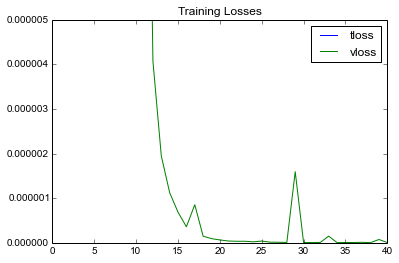

In [7]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.000005)
legend()
# looks like after 20 is enough. Use 25.

# Learning Rate 0.0005 Noise 0.05 Stability

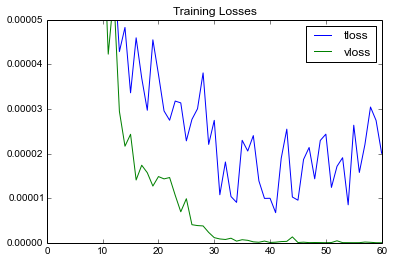

In [8]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like around 50

# Learning Rate 0.0005 Output Dropout 0.5 Stability

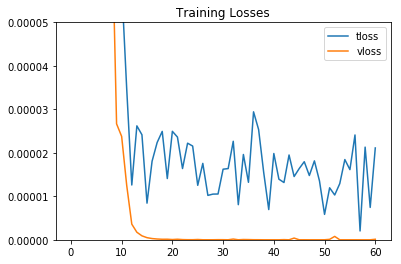

In [2]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like 25 is fine

# Learning Rate 0.0005 Output Dropout 0.5 Noise 0.05 Stability

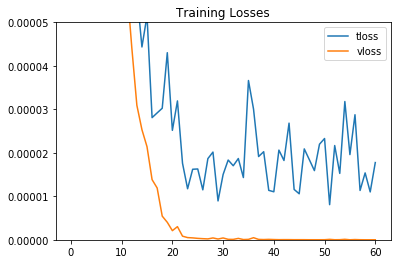

In [3]:
data11 = np.load('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.00005)
legend()
# looks like 45 again is fine

# Debug Memoize on Stability Runs

In [6]:
data11 = np.load('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/mem-runA0-epoch40.npz')
six.print_(data11.files)
mem_arrays = data11['mem_arrays']
six.print_(mem_arrays[0])
six.print_(mem_arrays[1])
six.print_(mem_arrays[5][1000])

['mem_arrays']
[[ 0.  0.  0.  0.]]
[[  9.99760926e-01   3.76824639e-03   8.07295844e-04   9.57022654e-04]
 [  9.99999642e-01   1.92387219e-04   1.35941254e-05   2.43485943e-06]
 [  9.99998569e-01   2.81491225e-06   1.97608519e-04   1.10886810e-06]
 [  9.99971271e-01   1.81344876e-05   1.97847603e-05   5.24370116e-05]
 [  9.99985337e-01   1.15873900e-05   2.18772057e-05   1.53569781e-05]
 [  9.99988198e-01   8.85017812e-02   7.98502413e-04   1.37441570e-03]
 [  9.99203026e-01   2.60969537e-04   4.24301326e-02   1.45776814e-03]
 [  9.99477923e-01   7.42685515e-04   2.93014711e-03   2.23981193e-03]]
[  9.99999881e-01   9.99945760e-01   6.82999162e-05   2.55893869e-03]


# Training Large Model No Regularization

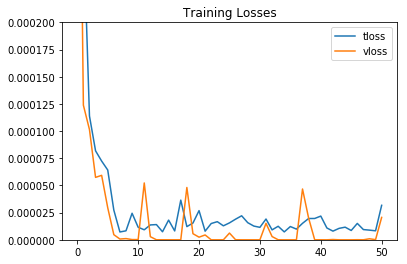

In [5]:
data11 = np.load('experiments/test2_modelgrusimple_large-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.0002)
legend()
# looks like 15 epochs is enough

# Training Large Model Noise 0.05

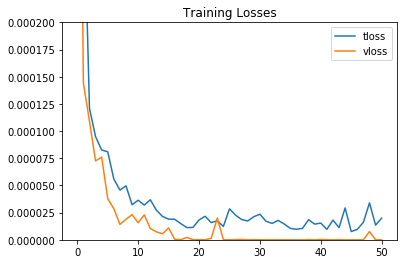

In [6]:
data11 = np.load('experiments/test2_modelgrusimple_large-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.0002)
legend()
# looks like 25 epochs is enough

# Training Large Model Output Dropout 0.5

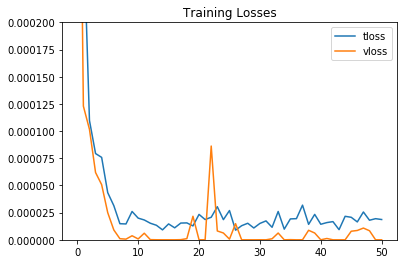

In [8]:
data11 = np.load('experiments/test2_modelgrusimple_large-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.0002)
legend()
# looks like 15 is fine

# Training Large Model Noise 0.05 + Output Dropout 0.5

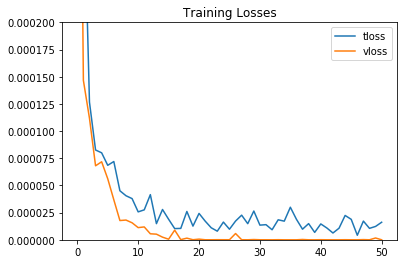

In [9]:
data11 = np.load('experiments/test2_modelgrusimple_large-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle/stats-runA.npz')

tloss = data11['tloss']
tloss_mean = np.mean(tloss,axis=0)
tloss_std = np.std(tloss,axis=0)/tloss.shape[0]

vloss = data11['vloss']
vloss_mean = np.mean(vloss,axis=0)
vloss_std = np.std(vloss,axis=0)/vloss.shape[0]

figure()
title('Training Losses')
plot(tloss_mean,label='tloss')
plot(vloss_mean,label='vloss')
ylim(0,0.0002)
legend()
# looks like 25 is fine

# No Noise

[ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  0.  1.
  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
40
1
2
Last step random 0.021504883655124433
Last step expert 0.40615082436721134
40
1
2
Ensemble last step random 0.010488700660060798
Ensemble last step expert 0.31188575171955246


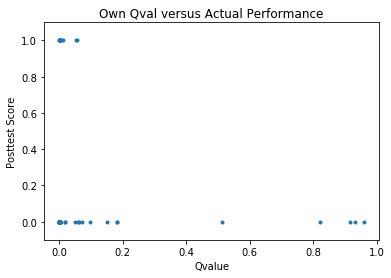

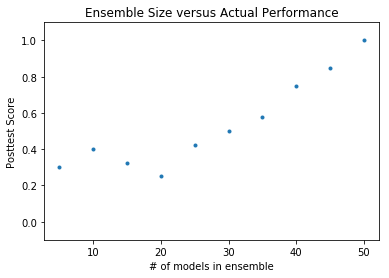

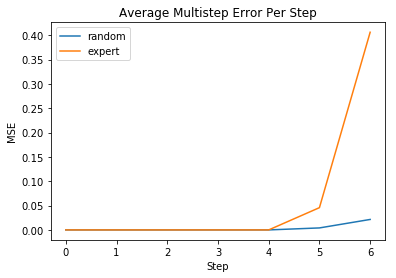

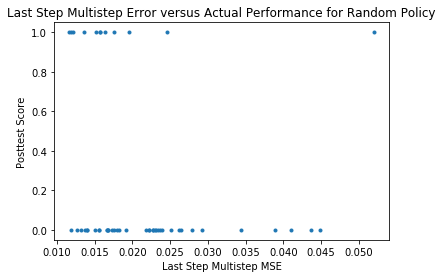

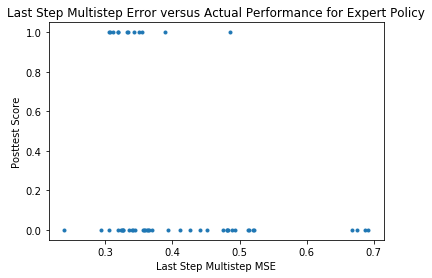

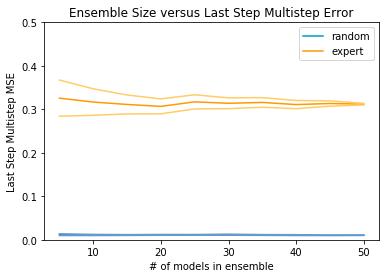

In [6]:
graph_info('experiments/test2_modelgrusimple_mid-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle')


In [ ]:
for i in six.moves.range(num_models):
    ix = sorted_by_fs_sq[i]
    six.print_('{:2d} | fs sim sq {:.1f} {:2d}th | vloss auc {:.5f} {:2d}th | fs sq {:.4f} {:2d}th'.format(
        ix, fs_sim_sq[ix], ranked_by_fs_sim_sq[ix], vloss_auc[ix], ranked_by_vloss[ix], fs_sq[ix], ranked_by_fs_sq[ix]))

# Noise 0.05

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.  1.
  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
40
1
2
Last step random 0.013945506760290811
Last step expert 0.44131754670809825
40
1
2
Ensemble last step random 0.007426779889556851
Ensemble last step expert 0.3535082933544781


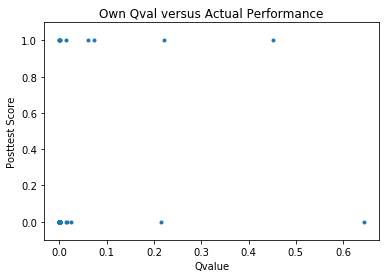

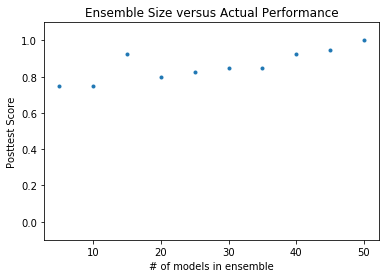

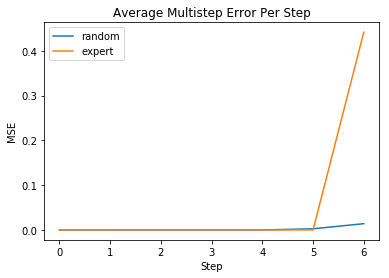

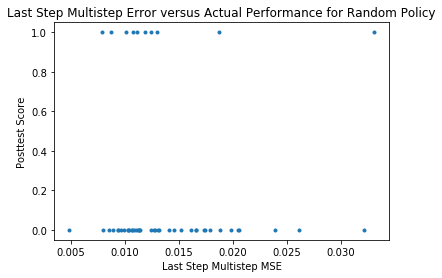

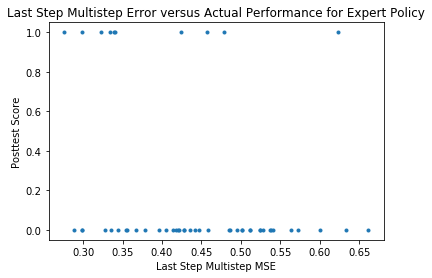

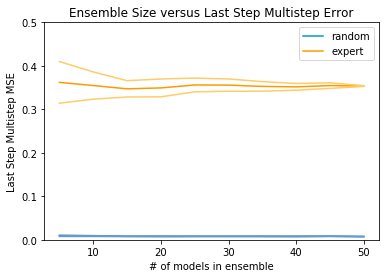

In [7]:
graph_info('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle')

In [ ]:
for i in six.moves.range(num_models):
    ix = sorted_by_fs_sq[i]
    six.print_('{:2d} | fs sim sq {:.1f} {:2d}th | vloss auc {:.5f} {:2d}th | fs sq {:.4f} {:2d}th'.format(
        ix, fs_sim_sq[ix], ranked_by_fs_sim_sq[ix], vloss_auc[ix], ranked_by_vloss[ix], fs_sq[ix], ranked_by_fs_sq[ix]))

# Output Dropout 0.5

[ 0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  1.  0.
  1.  0.  1.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
40
1
2
Last step random 0.020447464117680406
Last step expert 0.368141131649528
40
1
2
Ensemble last step random 0.01042538060617998
Ensemble last step expert 0.27855803293564446


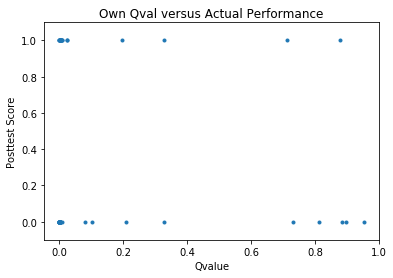

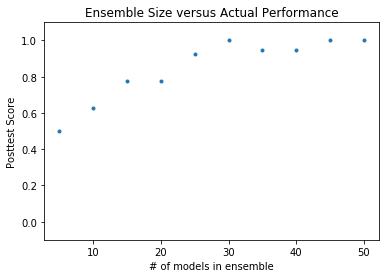

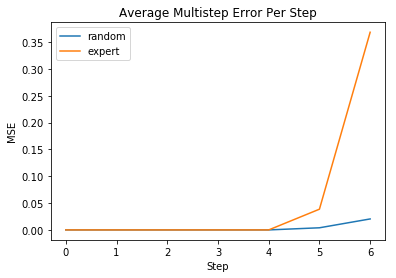

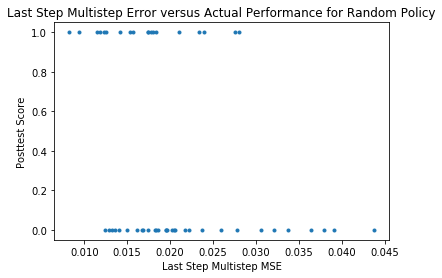

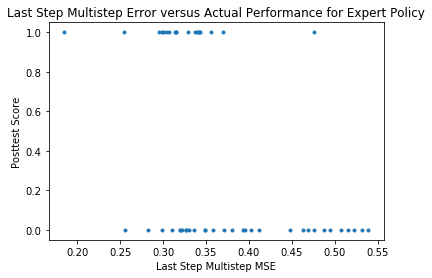

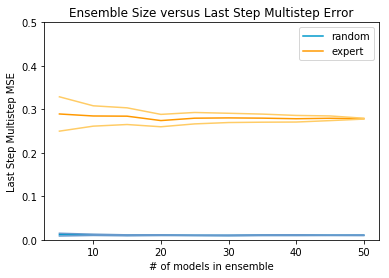

In [9]:
graph_info('experiments/test2_modelgrusimple_mid-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle')

# Output Dropout 0.5 Noise 0.05

[ 1.  0.  0.  0.  1.  0.  1.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
40
1
2
Last step random 0.01397857987890487
Last step expert 0.45845868536431283
40
1
2
Ensemble last step random 0.0073729947464916375
Ensemble last step expert 0.3630239348257182


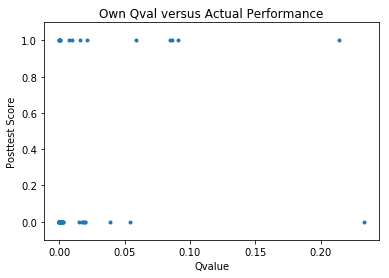

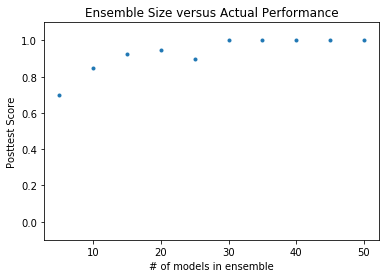

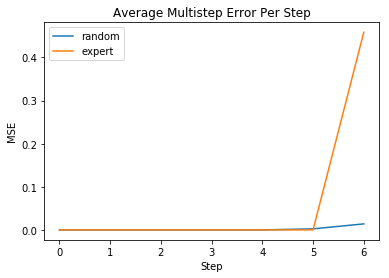

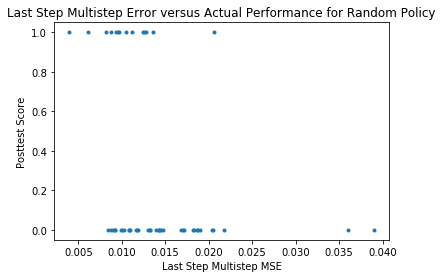

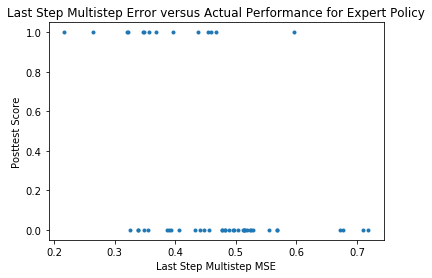

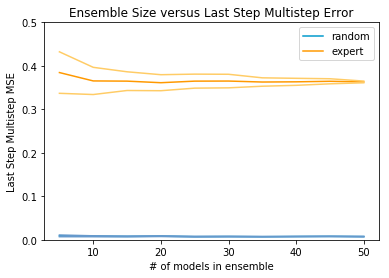

In [10]:
graph_info('experiments/test2_modelgrusimple_mid-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle')

# Large Model No Regularization

[ 0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.
  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.]
12.0
Last step random 0.012218578008413356
Last step expert 0.29060362562560454
Ensemble last step random 0.005977639484706079
Ensemble last step expert 0.2639131591004561


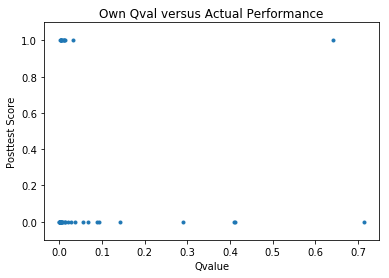

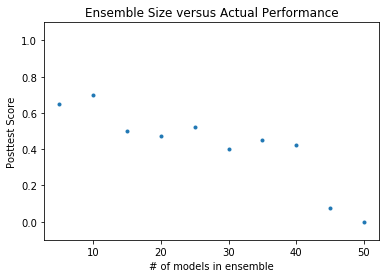

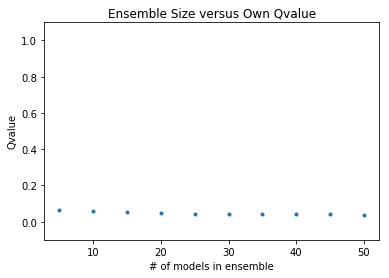

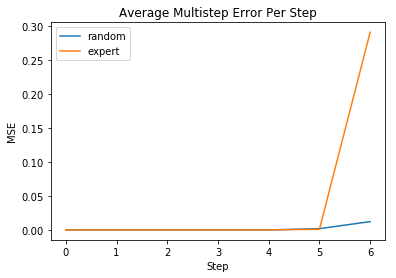

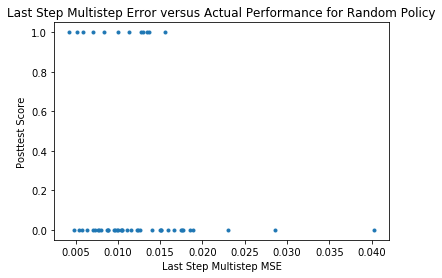

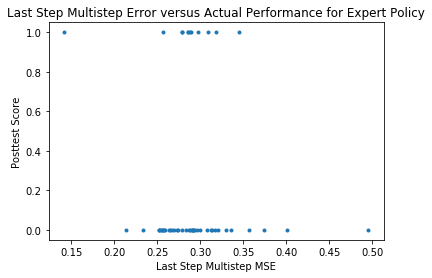

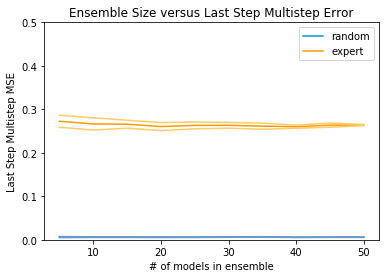

In [15]:
graph_info('experiments/test2_modelgrusimple_large-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle')

# Large Model Noise 0.05

[ 1.  0.  0.  0.  1.  1.  0.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.
  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  1.  1.  0.  0.  0.  1.
  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.]
25.0
Last step random 0.012965278243293896
Last step expert 0.3709964849734728
Ensemble last step random 0.006395545727095246
Ensemble last step expert 0.31180913429334856


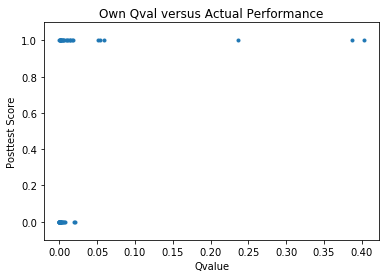

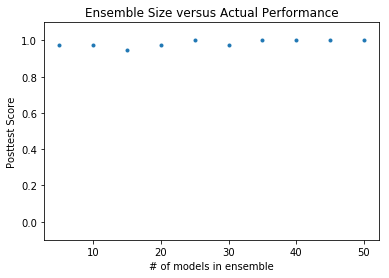

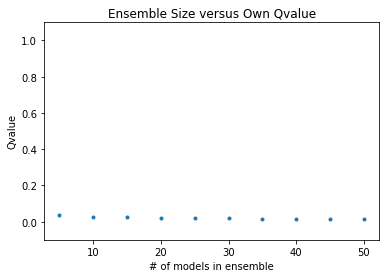

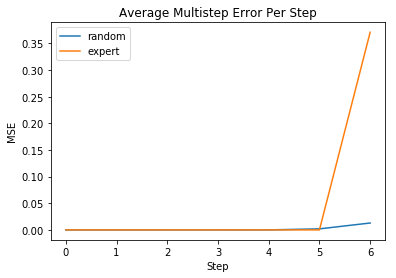

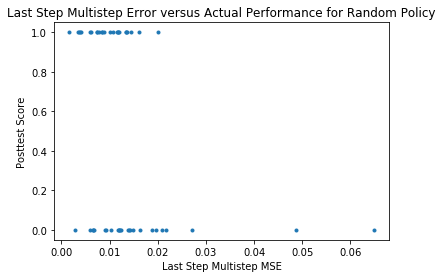

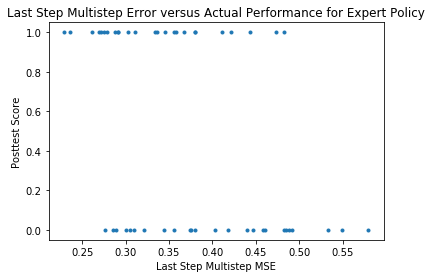

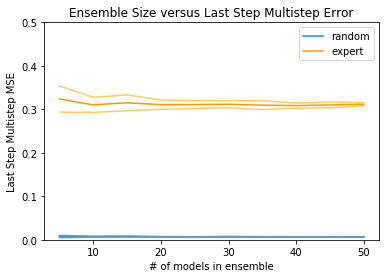

In [16]:
graph_info('experiments/test2_modelgrusimple_large-noise0.05-dropout10-shuffle1-data-test2a-w4-n100000-l5-random.pickle')

# Large Model Output Dropout 0.5

[ 0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  1.  1.  1.  0.  0.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0.]
20.0
Last step random 0.011270844531712988
Last step expert 0.2994131300181157
Ensemble last step random 0.005784102175881522
Ensemble last step expert 0.27293900710347946


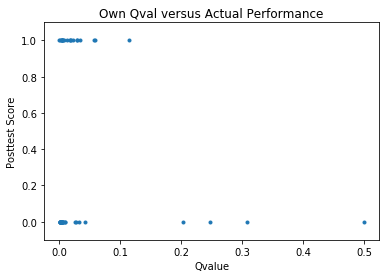

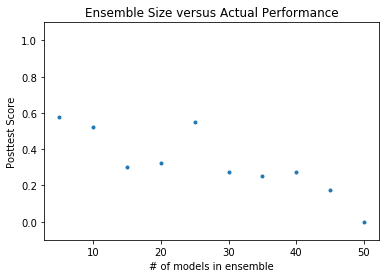

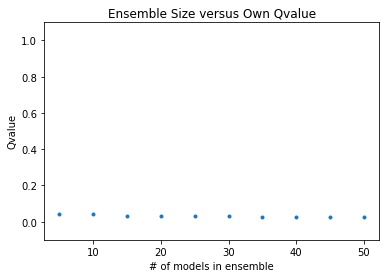

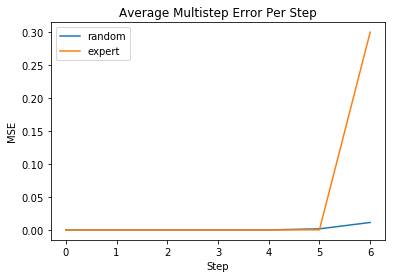

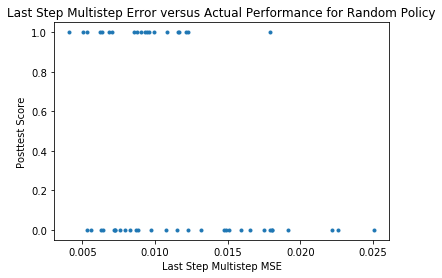

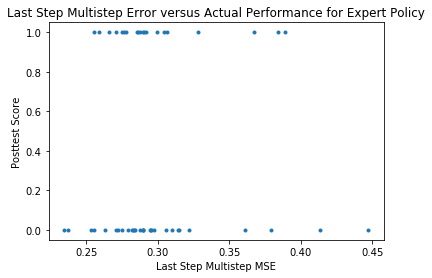

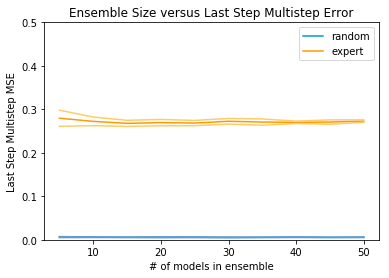

In [17]:
graph_info('experiments/test2_modelgrusimple_large-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle')

# Large Model Noise 0.05 + Output Dropout 0.5

[ 1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  1.  0.  1.  1.  1.
  1.  1.  0.  0.  1.  1.  1.  0.  0.  1.  0.  1.  1.  0.  1.  1.  0.  0.
  1.  1.  0.  0.  1.  0.  1.  1.  1.  0.  1.  1.  0.  1.]
29.0
Last step random 0.011262708755089734
Last step expert 0.35384416114701744
Ensemble last step random 0.0065180522272081836
Ensemble last step expert 0.29172347010016


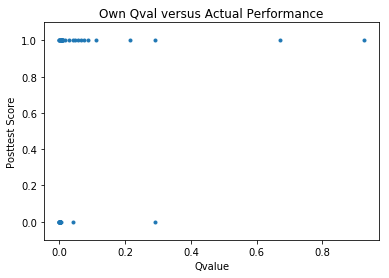

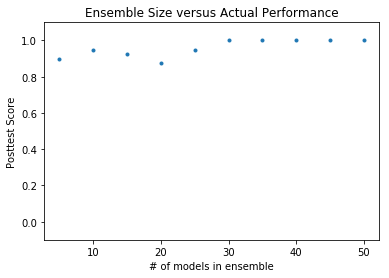

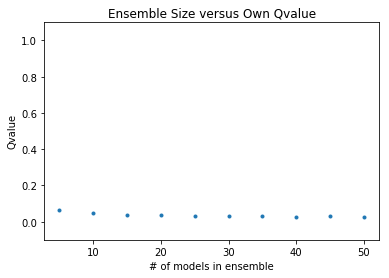

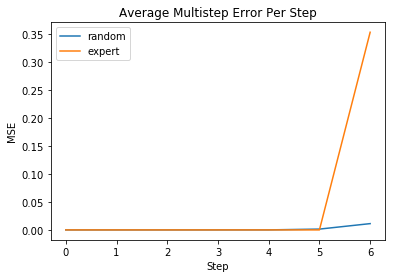

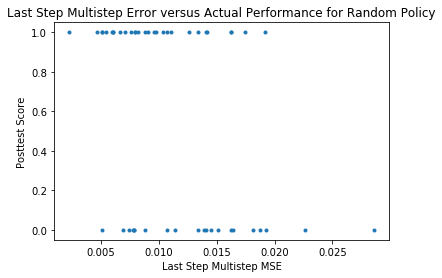

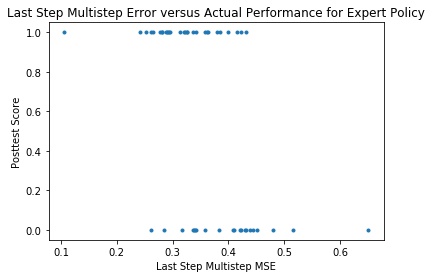

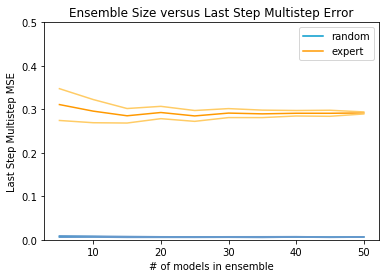

In [18]:
graph_info('experiments/test2_modelgrusimple_large-noise0.05-dropout10-outputdropout0.50-shuffle1-data-test2a-w4-n100000-l5-random.pickle')